## 1. Of cats and cookies
<p><a href="https://www.facebook.com/cookiecatsgame">Cookie Cats</a> is a hugely popular mobile puzzle game developed by <a href="http://tactile.dk">Tactile Entertainment</a>. It's a classic "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level. It also features singing cats. </p>

<p>As players progress through the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged.</p>
<p><img src="https://assets.datacamp.com/production/project_184/img/cc_gates.png" alt></p>
<p>But where should the gates be placed? Initially the first gate was placed at level 30, but in this notebook we're going to analyze an AB-test where we moved the first gate in Cookie Cats from level 30 to level 40. In particular, I will look at the impact on player retention.</p>

In [1]:
# Importing pandas
import pandas as pd
# Reading in the data
df = pd.read_csv("datasets/cookie_cats.csv")
# Showing the first few rows
print(df.head())

   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True


## 2. The AB-test data
<p>The data we have is from 90,189 players that installed the game while the AB-test was running. The variables are:</p>
<ul>
<li><code>userid</code> - a unique number that identifies each player.</li>
<li><code>version</code> - whether the player was put in the control group (<code>gate_30</code> - a gate at level 30) or the group with the moved gate (<code>gate_40</code> - a gate at level 40).</li>
<li><code>sum_gamerounds</code> - the number of game rounds played by the player during the first 14 days after install.</li>
<li><code>retention_1</code> - did the player come back and play <strong>1 day</strong> after installing?</li>
<li><code>retention_7</code> - did the player come back and play <strong>7 days</strong> after installing?</li>
</ul>
<p>When a player installed the game, he or she was randomly assigned to either <code>gate_30</code> or <code>gate_40</code>. Firstly, check if there are roughly the same number of players in each AB group. </p>

In [2]:
# Counting the number of players in each AB group.
num_by_group = df.groupby(["version"]).count()[["userid"]]
num_by_group.columns = ["Count"]
print(num_by_group)

         Count
version       
gate_30  44700
gate_40  45489


## 3. The distribution of game rounds
It looks like there is roughly the same number of players in each group.</p>
<p>Then plot the distribution of the number of game rounds players played during their first week playing the game.</p>

Text(0, 0.5, 'User Count')

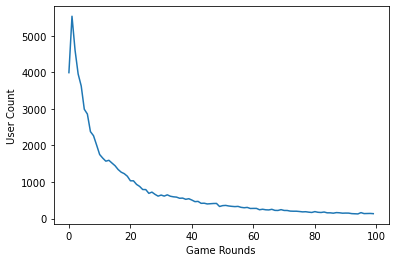

In [3]:
# This command makes plots appear in the notebook
%matplotlib inline

# Counting the number of players for each number of game rounds 
plot_df = df.groupby('sum_gamerounds')['userid'].count()

# Plotting the distribution of players that played 0 to 100 game rounds
ax = plot_df.head(100).plot(y=["userid"], x=["sum_gamerounds"]) 
ax.set_xlabel("Game Rounds")
ax.set_ylabel("User Count")

## 4. Overall 1-day retention
<p>In the plot above we can see that some players install the game but then never play it (0 game rounds), some players just play a couple of game rounds in their first week, and some get really hooked!</p>
<p>What I want is for players to like the game and to get hooked. A common metric in the video gaming industry for how fun and engaging a game is <em>1-day retention</em>: The percentage of players that comes back and plays the game <em>one day</em> after they have installed it.  The higher 1-day retention is, the easier it is to retain players and build a large player base. </p>
<p>As a first step, look at what 1-day retention is overall.</p>

In [4]:
# The % of users that came back the day after they installed
rate_retention_1 = df["retention_1"].mean()
print(rate_retention_1)

0.4452095044850259


## 5. 1-day retention by AB-group
So, a little less than half of the players come back one day after installing the game. Now that I have a benchmark. Then look at how 1-day retention differs between the two AB-groups.</p>

In [5]:
# Calculating 1-day retention for each AB-group
# ... YOUR CODE FOR TASK 5 ...
rate_retention_1_group = df.groupby("version")["retention_1"].mean()
print(rate_retention_1_group)

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64


## 6. Should we be confident in the difference?
<p>It appears that there was a slight decrease in 1-day retention when the gate was moved to level 40 (44.2%) compared to the control when it was at level 30 (44.8%). It's a small change, but even small changes in retention can have a large impact. But while we are certain of the difference in the data, how certain should we be that a gate at level 40 will be worse in the future?</p>
<p>Here I will use bootstrapping: repeatedly re-sample the dataset (with replacement) and calculate 1-day retention rate for those samples. The variation in 1-day retention rate will give us an indication of how uncertain the retention numbers are.</p>

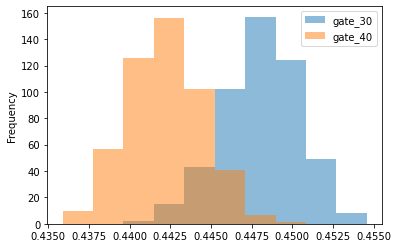

In [6]:
# Creating an list with bootstrapped means for each AB-group
boot_1d = []
for i in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby("version")['retention_1'].mean()
    boot_1d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d, columns=["gate_30", "gate_40"])
    
# A Kernel Density Estimate plot of the bootstrap distributions
ax = boot_1d.plot.hist(alpha=0.5)

## 7. Zooming in on the difference
<p>These two distributions above represent the bootstrap uncertainty over what the underlying 1-day retention could be for the two AB-groups. Just eyeballing this plot, we can see that there seems to be some evidence of a difference, albeit small. Let's zoom in on the difference in 1-day retention</p>

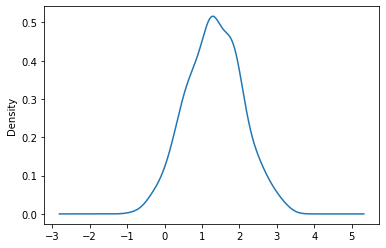

In [7]:
# Adding a column with the % difference between the two AB-groups
%matplotlib inline
boot_1d['diff'] = (boot_1d["gate_30"] - boot_1d["gate_40"])/boot_1d["gate_40"]*100

# Ploting the bootstrap % difference
ax = boot_1d['diff'].plot(kind = "kde")
ax.set_xlabel = "Diff"
# ... YOUR CODE FOR TASK 7 ...

## 8. The probability of a difference
<p>From this chart, we can see that the most likely % difference is around 1% - 2%, and that most of the distribution is above 0%, in favor of a gate at level 30. Compute the <em>probability</em> that the difference is above 0% as well.</p>

In [8]:
# Calculating the probability that 1-day retention is greater when the gate is at level 30
prob = (boot_1d['diff']>0).mean()

# Pretty printing the probability
'{:.1%}'.format(prob)

'96.4%'

## 9. 7-day retention by AB-group
<p>The bootstrap analysis tells us that there is a high probability that 1-day retention is better when the gate is at level 30. However, since players have only been playing the game for one day, it is likely that most players haven't reached level 30 yet. That is, many players won't have been affected by the gate, even if it's as early as level 30. </p>
<p>But after having played for a week, more players should have reached level 40, and therefore it makes sense to also look at 7-day retention. That is: What percentage of the people that installed the game also showed up a week later to play the game again.</p>
<p>Then calculate 7-day retention for the two AB-groups.</p>

In [9]:
# Calculating 7-day retention for both AB-groups
rate_retension_7_group = df.groupby("version")["retention_7"].mean()
print(rate_retension_7_group)

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64


## 10. Bootstrapping the difference again
<p>Like with 1-day retention, we see that 7-day retention is slightly lower (18.2%) when the gate is at level 40 than when the gate is at level 30 (19.0%). This difference is also larger than for 1-day retention, presumably because more players have had time to hit the first gate. We also see that the <em>overall</em> 7-day retention is lower than the <em>overall</em> 1-day retention; fewer people play a game a week after installing than a day after installing.</p>
<p>But as before, let's use bootstrap analysis to figure out how certain we should be of the difference between the AB-groups.</p>

'99.8%'

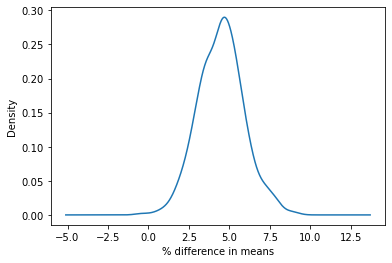

In [10]:
# Creating a list with bootstrapped means for each AB-group
boot_7d = []
for i in range(500):
    boot_mean = df.sample(frac = 1, replace = True).groupby("version")["retention_7"].mean()
    boot_7d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_7d = pd.DataFrame(boot_7d, columns=["gate_30", "gate_40"])
# Adding a column with the % difference between the two AB-groups
boot_7d['diff'] = (boot_7d["gate_30"] - boot_7d["gate_40"])/boot_7d["gate_40"] *100

# Ploting the bootstrap % difference
ax = boot_7d["diff"].plot(kind = "kde")
ax.set_xlabel("% difference in means")

# Calculating the probability that 7-day retention is greater when the gate is at level 30
prob = (boot_7d['diff'] > 0).mean()
'{:.1%}'.format(prob)